Set up data:
-
This is a collection of real data about the COVID-19 numbers throughout the US during 2021.

In [2]:
import numpy as np
import pandas as pd
import re
import sklearn.linear_model
import sklearn.neighbors
import sklearn.tree
from sklearn.model_selection import cross_val_score
from scipy.stats import ttest_ind

covid_data = pd.read_csv('national-history.csv')
print(covid_data)

           date     death  deathIncrease  inIcuCumulative  inIcuCurrently  \
0    2021-03-07  515151.0            842          45475.0          8134.0   
1    2021-03-06  514309.0           1680          45453.0          8409.0   
2    2021-03-05  512629.0           2221          45373.0          8634.0   
3    2021-03-04  510408.0           1743          45293.0          8970.0   
4    2021-03-03  508665.0           2449          45214.0          9359.0   
..          ...       ...            ...              ...             ...   
415  2020-01-17       NaN              0              NaN             NaN   
416  2020-01-16       NaN              0              NaN             NaN   
417  2020-01-15       NaN              0              NaN             NaN   
418  2020-01-14       NaN              0              NaN             NaN   
419  2020-01-13       NaN              0              NaN             NaN   

     hospitalizedIncrease  hospitalizedCurrently  hospitalizedCumulative  \

In [3]:
covid_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420 entries, 0 to 419
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   date                      420 non-null    object 
 1   death                     392 non-null    float64
 2   deathIncrease             420 non-null    int64  
 3   inIcuCumulative           348 non-null    float64
 4   inIcuCurrently            347 non-null    float64
 5   hospitalizedIncrease      420 non-null    int64  
 6   hospitalizedCurrently     356 non-null    float64
 7   hospitalizedCumulative    369 non-null    float64
 8   negative                  372 non-null    float64
 9   negativeIncrease          420 non-null    int64  
 10  onVentilatorCumulative    341 non-null    float64
 11  onVentilatorCurrently     348 non-null    float64
 12  positive                  419 non-null    float64
 13  positiveIncrease          420 non-null    int64  
 14  states    

In [4]:
covid_data.describe()

,death,deathIncrease,inIcuCumulative,inIcuCurrently,hospitalizedIncrease,hospitalizedCurrently,hospitalizedCumulative,negative,negativeIncrease,onVentilatorCumulative,onVentilatorCurrently,positive,positiveIncrease,states,totalTestResults,totalTestResultsIncrease
count,392.000000,420.000000,348.000000,347.000000,420.000000,356.000000,369.000000,3.720000e+02,420.000000,341.000000,348.000000,4.190000e+02,420.000000,420.000000,4.200000e+02,4.200000e+02
mean,187210.668367,1226.550000,21059.344828,12059.227666,1848.478571,57987.117978,310817.140921,3.030351e+07,177578.154762,2173.932551,3975.298851,8.116687e+06,68467.830952,49.476190,1.073369e+08,8.662503e+05
std,142331.657380,1070.129644,13572.638376,5668.415483,1708.460481,31898.555998,235557.870159,2.407815e+07,121544.473208,1327.372196,2191.080602,8.967432e+06,68682.221496,16.896764,1.129172e+08,6.579460e+05
min,0.000000,0.000000,74.000000,1299.000000,-2858.000000,325.000000,4.000000,2.000000e+00,-658774.000000,32.000000,167.000000,0.000000e+00,0.000000,1.000000,0.000000e+00,0.000000e+00
25%,86911.750000,439.750000,9900.250000,7495.500000,765.750000,35100.500000,123250.000000,6.753778e+06,79236.750000,951.000000,2168.500000,1.004386e+06,22462.500000,56.000000,5.888598e+06,2.388558e+05
50%,169118.500000,1016.000000,18797.500000,10114.000000,1490.000000,48811.000000,280138.000000,2.757246e+07,206620.000000,2107.000000,3186.500000,5.044337e+06,44664.500000,56.000000,6.839699e+07,8.223685e+05
75%,258912.250000,1642.500000,32998.500000,15596.500000,2467.000000,70519.250000,481309.000000,5.084301e+07,260621.000000,3430.000000,5828.500000,1.234137e+07,89684.250000,56.000000,1.854937e+08,1.401706e+06
max,515151.000000,5427.000000,45475.000000,23912.000000,17155.000000,132474.000000,776361.000000,7.458282e+07,480256.000000,4281.000000,8004.000000,2.875649e+07,295121.000000,56.000000,3.638251e+08,2.309884e+06


Clean the data
-
- Deal with missing/empty values
- Fix numeric columns so that they contain numbers
- Remove inconsistencies from columns
- Assign a data type to each column

In [5]:
def clean_data(frame):
    # Drop duplicates and empty rows
    frame = frame.drop_duplicates()
    frame = frame.dropna()

    # Standardize column names
    frame.columns = [col.strip().lower().replace(' ', '_') for col in frame.columns]

    # Convert date column to datetime format
    frame['date'] = pd.to_datetime(frame['date'], errors='coerce')

    # Convert numerical columns to appropriate data types
    numerical_cols = frame.columns.drop('date')
    frame[numerical_cols] = frame[numerical_cols].apply(pd.to_numeric, errors='coerce')

    # Fill missing values with 0
    frame = frame.fillna(0)
    
    return frame

covid_data = clean_data(covid_data)
print(covid_data)

          date     death  deathincrease  inicucumulative  inicucurrently  \
0   2021-03-07  515151.0            842          45475.0          8134.0   
1   2021-03-06  514309.0           1680          45453.0          8409.0   
2   2021-03-05  512629.0           2221          45373.0          8634.0   
3   2021-03-04  510408.0           1743          45293.0          8970.0   
4   2021-03-03  508665.0           2449          45214.0          9359.0   
..         ...       ...            ...              ...             ...   
336 2020-04-05   10618.0           1340            609.0          5811.0   
337 2020-04-04    9278.0           1478            403.0          5500.0   
338 2020-04-03    7800.0           1288            335.0          4928.0   
339 2020-04-02    6512.0           1175            305.0          4513.0   
340 2020-04-01    5337.0           1006            256.0          3937.0   

     hospitalizedincrease  hospitalizedcurrently  hospitalizedcumulative  \
0          

Data Visualization
-
1. Line Plot of Total Deaths Over Time

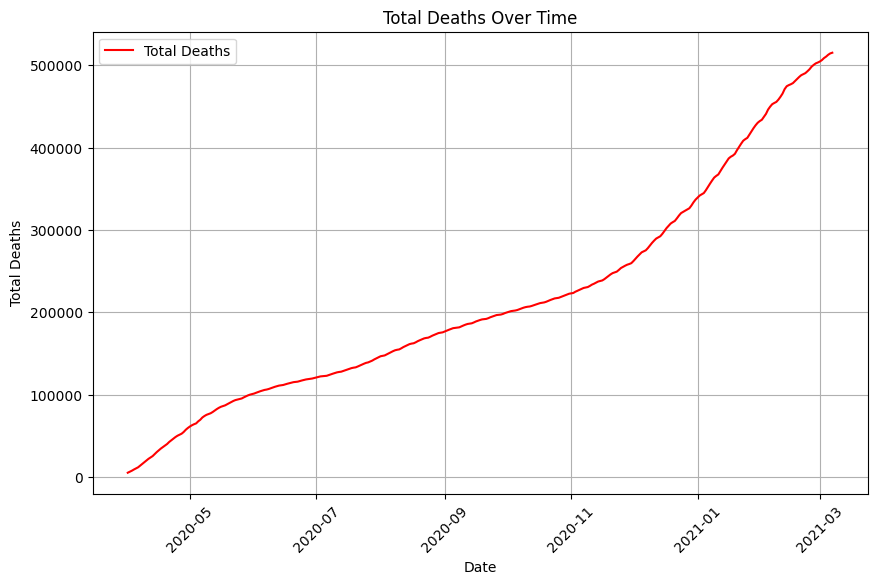

In [6]:
import matplotlib.pyplot as plt

# Line plot of total deaths over time
plt.figure(figsize=(10, 6))
plt.plot(covid_data['date'], covid_data['death'], label='Total Deaths', color='red')
plt.xlabel('Date')
plt.ylabel('Total Deaths')
plt.title('Total Deaths Over Time')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

2. Scatter Plot of Positive Cases vs. Deaths

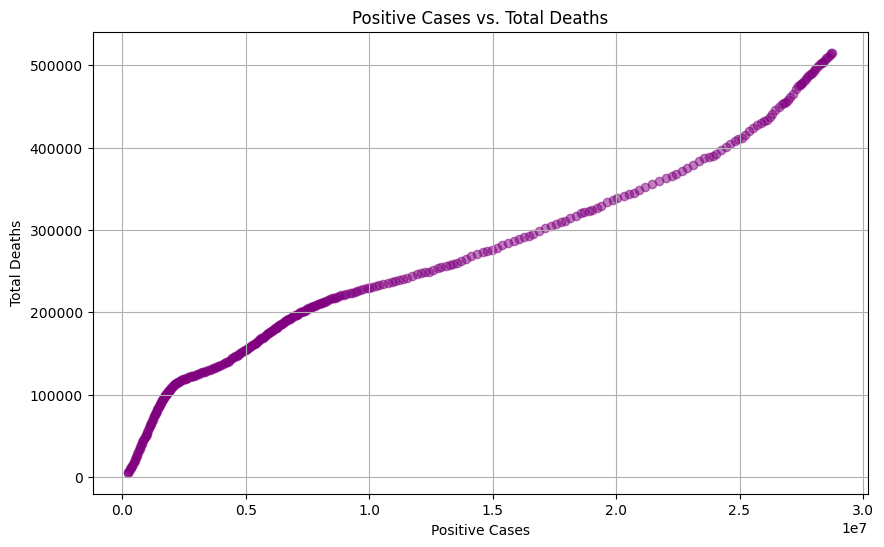

In [9]:
plt.figure(figsize=(10, 6))
plt.scatter(covid_data['positive'], covid_data['death'], alpha=0.5, color='purple')
plt.xlabel('Positive Cases')
plt.ylabel('Total Deaths')
plt.title('Positive Cases vs. Total Deaths')
plt.grid(True)
plt.show()

Modeling
-

1. We can use linear regression to predict deaths based on the nuber of positive cases.

- The code below takes the data and splits it into two sets - testing and training data using train_test_split and sklearn.model_selection
- It then creates a linear regression model using LinearRegression from sklearn.linear_model
- Then, it trains the model using model.fit on the training data
- With the trained model, it predicts the target values for the testing data set using model.predict
- Evaluate the mdoel's performance using the Mean Squared Error from sklearn.metrics
- Plot the acutal vs. predicted values to visualize the model's performance

Mean Squared Error: 532753901.48472637


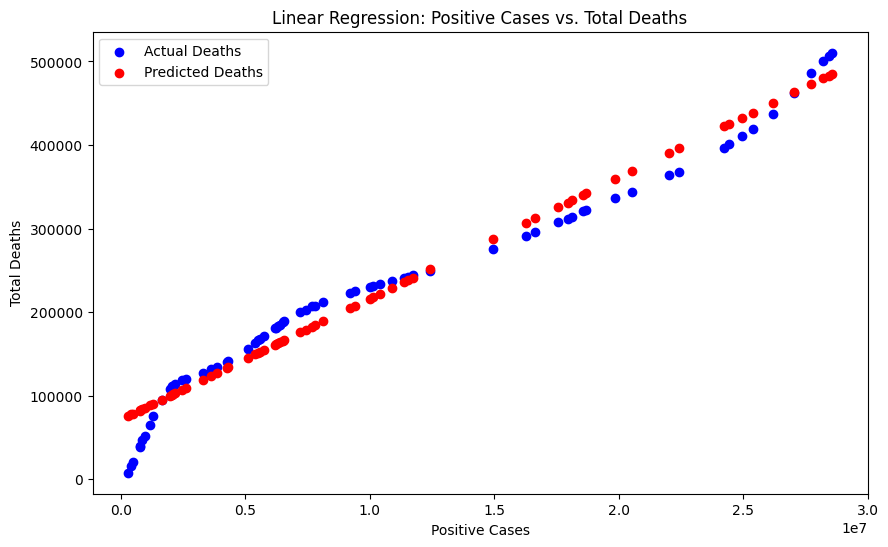

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Prepare the data
X = covid_data[['positive']].dropna()
y = covid_data[['death']].dropna()

# Ensure X and y have the same indices
common_indices = X.index.intersection(y.index)
X = X.loc[common_indices]
y = y.loc[common_indices]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_test, color='blue', label='Actual Deaths')
plt.scatter(X_test, y_pred, color='red', label='Predicted Deaths')
plt.xlabel('Positive Cases')
plt.ylabel('Total Deaths')
plt.title('Linear Regression: Positive Cases vs. Total Deaths')
plt.legend()
plt.show()

2. We can use random forest regression to also help understand and predict the relationship between positve cases and death. In this case, we use mean squared error to see how well the model performs in predicting the outcomes. If there is a lower mean squared error, then there is a better fit of the model to the data.
- In the scatter plot, the red dots represent the predicted deaths. The blue dots represent the actual deaths
- The red and blue dots are very close to each other, so the predicted deaths is accurate with the acutal deaths
- The mean squared error is 882386.8871318814 which indicates a good fit to the model of data

Mean Squared Error: 882386.8871318814


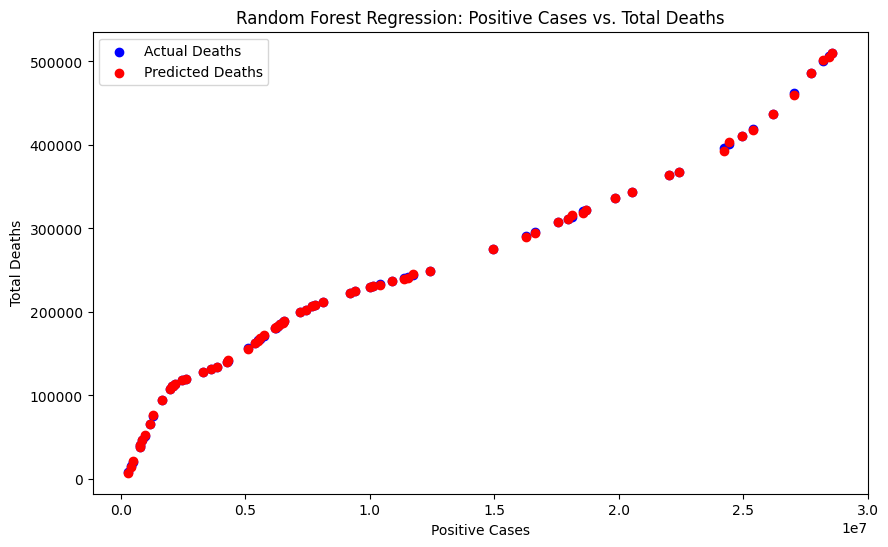

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Assuming covid_data is already loaded and cleaned
# Prepare the data
X = covid_data[['positive']].dropna()
y = covid_data[['death']].dropna()

# Ensure X and y have the same indices
common_indices = X.index.intersection(y.index)
X = X.loc[common_indices]
y = y.loc[common_indices]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train.values.ravel())

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_test, color='blue', label='Actual Deaths')
plt.scatter(X_test, y_pred, color='red', label='Predicted Deaths')
plt.xlabel('Positive Cases')
plt.ylabel('Total Deaths')
plt.title('Random Forest Regression: Positive Cases vs. Total Deaths')
plt.legend()
plt.show()
